### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количество слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом - https://github.com/DmitryInd/pytorch-machine-translation

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский.

In [1]:
# !wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

### Вспомогательные функции

In [20]:
# %pip install sentencepiece torchtext huggingface-hub transformers tokenizer

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.3 MB 1.7 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [32]:
#!g1.1
# Кажется, у меня проблемы с драйверами для видеокарты, из-за чего обучение может в произвольный момент падать
# Запрет асинхронных запусков ядра не решает проблему полностью, но заметно снижает вероятность её возникновения
# import os
# os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [34]:
#!g1.1
import torch
import numpy as np

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [35]:
#!g1.1
def print_learning_parameters(data_config, model_config):
    print(f"Parameters of the model:")
    print(f"* Learning rate is {model_config['learning_rate']}.")
    if 'div_factor' in model_config:
        print(f"* OneCycleLR with warm up and linear decrease of learning rate to division factor {model_config['div_factor']} is in use.")
    else:
        print("* Adafactor with constant learning rate is in use.")
    print(f"* Batch size is {data_config['batch_size']}.")
    if data_config['pretrained_input_tokenizer_name'] is not None:
        print(f"* The tokenizer for input values uses the pretrained vocabulary from '{data_config['pretrained_input_tokenizer_name']}'.")
    if data_config['pretrained_output_tokenizer_name'] is not None:
        print(f"* The tokenizer for output values uses the pretrained vocabulary from '{data_config['pretrained_output_tokenizer_name']}'.")
    print(f"* The number of epochs is {model_config['epoch_num']}.")
    if "pretrained_model_name" in model_config:
        print(f"* Pretrained parameters from '{model_config['pretrained_model_name']}' is used.")
    if 'emb_size' in model_config:
        print(f"* The size of embeddings/hidden states is {model_config['emb_size']}.")
    if 'num_encoder_layers' in model_config and 'num_decoder_layers' in model_config:
        print(f"* The numbers of encoder and decoder layers are {model_config['num_encoder_layers']} and {model_config['num_decoder_layers']}.")
    if 'num_heads' in model_config:
        print(f"* There are {model_config['num_heads']} heads for self-attention and encoder-decoder attention")

In [36]:
#!g1.1
import re
import matplotlib.pylab as plt

MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]

        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()

    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()

    fig.suptitle(run_name, fontsize=20)
    plt.show()

In [7]:
#!g1.1
def print_demo_translations(model, val_dataloader, input_tokenizer, sentence_num=10):
    input_tensor, target_tensor = val_dataloader.__iter__().__next__()
    input_tensor = input_tensor[:sentence_num]
    target_tensor = target_tensor[:sentence_num]
    with torch.no_grad():
        predicted_samples, _ = model.forward(input_tensor)
    bleu_score, actual_sentences, predicted_sentences = model.eval_bleu(predicted_samples, target_tensor)
    print(f'BLEU score on the following sentences is {bleu_score}.')
    print("* Original sentence\t| True translation\t| Predicted translation")
    for in_tens, actual, pred in zip(input_tensor, actual_sentences, predicted_sentences):
        print(f"* {' '.join(input_tokenizer.decode(in_tens.tolist()))}\t| {actual}\t| {pred}")
    print('##############################')

In [37]:
#!g1.1
import sys  
sys.path.insert(1, "./src")

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позиционных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate scheduler


В качестве результатов, приложите следующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количество слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [38]:
#!g1.1
import yaml
from models import trainer
from data.datamodule import DataManager
from txt_logger import TXTLogger
from models.seq2seq_transformer import Seq2SeqTransformer
from models.seq2seq_t5 import Seq2SeqT5

### Конфигурация модели и алгоритма обучения

In [10]:
#!g1.1
transformer_data_config = yaml.load(open("configs/data_config.yaml", 'r'),   Loader=yaml.Loader)
transformer_model_config = yaml.load(open("configs/transformer_config.yaml", 'r'),   Loader=yaml.Loader)
print_learning_parameters(transformer_data_config, transformer_model_config)

Parameters of the model:
* Learning rate is 0.0001.
* OneCycleLR with warm up and linear decrease of learning rate to division factor 10000 is in use.
* Batch size is 256.
* The number of epochs is 5.
* The size of embeddings/hidden states is 510.
* The numbers of encoder and decoder layers are 4 and 4.
* There are 6 heads for self-attention and encoder-decoder attention


### Обучение модели

In [11]:
#!g1.1
tran_dm = DataManager(transformer_data_config, DEVICE)
tran_train_dataloader, tran_val_dataloader = tran_dm.prepare_data()

transformer = Seq2SeqTransformer(
    device=DEVICE,
    encoder_vocab_size=len(tran_dm.source_tokenizer.index2word),
    decoder_vocab_size=len(tran_dm.target_tokenizer.index2word),
    target_tokenizer=tran_dm.target_tokenizer,
    start_symbol=tran_dm.target_tokenizer.sos_token,
    lr=transformer_model_config['learning_rate'],
    total_steps=transformer_model_config['epoch_num']*len(tran_train_dataloader),
    emb_size=transformer_model_config['emb_size'],
    num_heads=transformer_model_config['num_heads'],
    num_encoder_layers=transformer_model_config['num_encoder_layers'],
    num_decoder_layers=transformer_model_config['num_decoder_layers'],
    dropout=transformer_model_config['dropout'],
    div_factor=transformer_model_config['div_factor']
)

tran_logger = TXTLogger(transformer_model_config['path_to_log'])
tran_trainer_cls = trainer.Trainer(model=transformer, model_config=transformer_model_config, logger=tran_logger)

if transformer_model_config['try_one_batch']:
    tran_train_dataloader = [list(tran_train_dataloader)[0]]
    tran_val_dataloader = [list(tran_val_dataloader)[0]]

tran_trainer_cls.train(tran_train_dataloader, tran_val_dataloader)

Reading from file: 100%|██████████| 467119/467119 [00:09<00:00, 51122.43it/s]


Current BLEU:  0.014843137352727354
думаю нам следует сосредоточиться на другом ---> думаю мы мы нас на на на
развитые страны должны помогать развивающимся странам ---> она бы должны должны должны бы не не
не думаю что том знает насколько мэри богата ---> не думаю что том знает что мэри мэри мэри мэри
мы с томом оба неплохо играем в шахматы ---> мы с с с и и и и и и
достижения тома говорят сами за себя ---> у тома тома на на на
##############################


Current BLEU:  0.04792803057094453
не думаю что у тома есть права ---> не думаю что у тома есть есть
сколько денег ты вчера потратил ---> сколько денег ты ты вчера
хорошо что с нами этого не случилось ---> это это что не не
я тут тебе кое что купил ---> это немного немного что что для для
том подошёл к тому месту где стояла мэри ---> том пошёл куда где мэри мэри
##############################


Current BLEU:  0.058118366604211685
я вижу тома всякий раз когда он приезжает в бостон ---> я вижу тома тома раз он в бостон бостон бостон
многие молодые люди больше не слушают радио ---> многие людей больше не не не
я не знал точно на какой поезд садиться ---> я не знал что на на на на
тому хотелось пить и он попросил воды ---> том был пить и и воды воды воды
ты помнишь какие уроки у нас были в понедельник ---> ты помнишь что что мы мы в понедельник
##############################


Current BLEU:  0.06061710773151908
том оторвал половые доски лапчатым ломом ---> том спрятался с в
том растянулся на диване и уснул ---> том вышел на и и и
том бы помог тебе если бы ты попросил ---> том бы бы бы если если ли его его
ты мог мне сказать я бы понял ---> ты мог бы бы мне мне что я
том хотел поговорить с мэри лицом к лицу ---> том хотел поговорить с с с мэри
##############################


Current BLEU:  0.062108134950488426
не знаю такая ли уж это хорошая идея ---> я не знаю ли ли это идея идея
надеюсь ты не поймёшь это неправильно ---> надеюсь ты не не не так так
я возвращаюсь к своей бывшей ---> я начинаю вместе с с с
прибейте объявление к стволу этого дерева ---> мост заметил на на на на
мой сосед вызвал пожарных ---> мой мою вызвал огонь огонь
##############################
Last 4 epoch train loss:  0.9829304785807845
Last 4 epoch val loss:  2.3438950747251512
Last 4 epoch val bleu:  0.062108134950488426


In [12]:
#!g1.1
import os
file_content = open(os.path.join(transformer_model_config['path_to_log'], "progress_log.txt"), 'r').read().split("\n")
tran_train_loss_list, tran_val_loss_list, tran_val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        tran_train_loss_list.append(d['train_loss'])
        tran_val_loss_list.append(d['val_loss'])
        tran_val_bleu_list.append(d['bleu_score'])

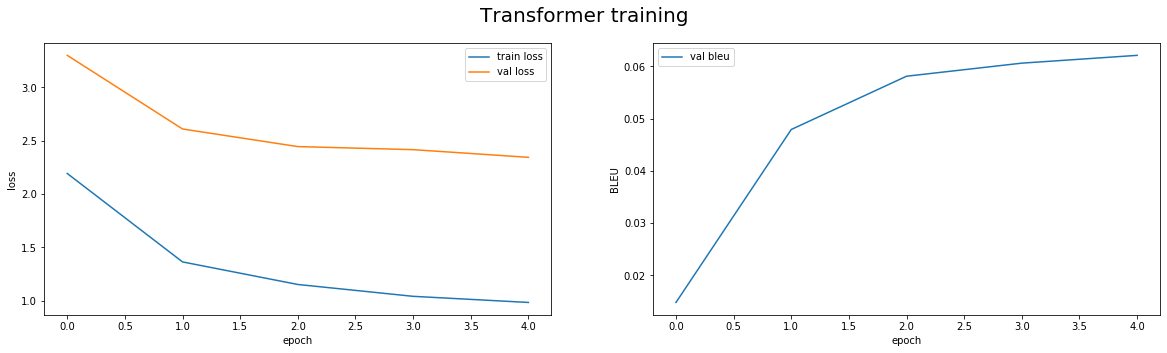

In [13]:
#!g1.1
plot_results(tran_train_loss_list, tran_val_loss_list, tran_val_bleu_list, run_name='Transformer training')

### Итоговое качество модели/примеры переводов

In [14]:
#!g1.1
print(f"Final BLUE score is {tran_val_bleu_list[-1]}.")
print(f"The best BLUE score is {max(tran_val_bleu_list)} on {np.argmax(tran_val_bleu_list) + 1} step.")

Final BLUE score is 0.062108134950488426.
The best BLUE score is 0.062108134950488426 on 5 step.


In [15]:
#!g1.1
print_demo_translations(transformer, tran_val_dataloader, tran_dm.source_tokenizer)

BLEU score on the following sentences is 0.08408964276313782.
* Original sentence	| True translation	| Predicted translation
* didn t you know that i was from boston	| ты не знал что я из бостона	| ты не знал что я из бостона бостона
* the minister approved the building plans	| министр одобрил планы строительства	| погода несколько здание здание здание
* are your parents still living in boston	| твои родители ещё живут в бостоне	| твои родители ещё ещё в в бостоне
* those kinds of things often take a lot of time	| подобные вещи часто занимают много времени	| эти много часто много много времени времени времени времени
* we bought our plane tickets two months in advance	| мы купили билеты на самолёт за два месяца до вылета	| мы купили наши в два два два два две
* we ordered pink but we received blue	| мы заказали розовый а получили синий	| мы заказал мы но но мы мы
* tom saw that mary wasn t happy and went over to cheer	| том видел что мэри расстроена и подошел ее приободрить	| том видел

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количество слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate scheduler/Adafactor with constant learning rate


В качестве результатов, приложите следующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

### Конфигурация модели и алгоритма обучения

In [46]:
#!g1.1
t5_data_config = yaml.load(open("configs/data_t5_config.yaml", 'r'),   Loader=yaml.Loader)
t5_model_config = yaml.load(open("configs/model_t5_config.yaml", 'r'),   Loader=yaml.Loader)
print_learning_parameters(t5_data_config, t5_model_config)

Parameters of the model:
* Learning rate is 0.001.
* Adafactor with constant learning rate is in use.
* Batch size is 256.
* The tokenizer for input values uses the pretrained vocabulary from 'google/t5-efficient-mini'.
* The tokenizer for output values uses the pretrained vocabulary from 'ai-forever/ruT5-base'.
* The number of epochs is 5.
* Pretrained parameters from 'google/t5-efficient-mini' is used.


### Обучение модели

In [47]:
#!g1.1
t5_dm = DataManager(t5_data_config, DEVICE)
t5_train_dataloader, t5_val_dataloader = t5_dm.prepare_data()

t5_model = Seq2SeqT5(
    device=DEVICE,
    pretrained_name=t5_model_config['pretrained_model_name'],
    encoder_vocab_size=len(t5_dm.source_tokenizer.index2word),
    decoder_vocab_size=len(t5_dm.target_tokenizer.index2word),
    target_tokenizer=t5_dm.target_tokenizer,
    start_symbol=t5_dm.target_tokenizer.pad_token,
    lr=t5_model_config['learning_rate'],
    are_source_target_tokenizers_same=t5_model_config['are_source_target_tokenizers_same']
)

t5_logger = TXTLogger(t5_model_config['path_to_log'])
t5_trainer_cls = trainer.Trainer(model=t5_model, model_config=t5_model_config, logger=t5_logger)

if t5_model_config['try_one_batch']:
    train_dataloader = [list(t5_train_dataloader)[0]]
    tran_val_dataloader = [list(t5_val_dataloader)[0]]

t5_trainer_cls.train(t5_train_dataloader, t5_val_dataloader)

Reading from file: 100%|██████████| 467119/467119 [00:09<00:00, 50751.36it/s]


Current BLEU:  0.0
не может себе сейчас позволить покупку машины ---> 
заказал два чая и три кофе ---> 
спас своего друга ценой собственной жизни ---> 
ничего не видит без очков ---> 
не мог заставить себя застрелить оленя ---> 
##############################


Current BLEU:  0.0
пойдёт дождь нам бы лучше взять зонтик ---> 
хочет стать синхронным переводчиком ---> 
подобное могло разрушить вам карьеру ---> 
никогда никуда не ходит без своей собаки ---> 
последний раз говорю тебе чтобы ты это сделал ---> 
##############################


Current BLEU:  0.0
постоянно путаю эти два слова ---> в в в в в
сказал мне что будет здесь около половины третьего ---> что что что что
строят длинный мост через канал ---> в в в в
том сможет завтра помочь мэри ---> что том мэр мэр мэри
сожалению у меня нет сейчас с собой денег ---> не не не не я
##############################


Current BLEU:  0.0
меня нет другого выбора кроме как сделать то о чём меня попросил том ---> меня не с что что том том том тому
сёстры все старше тебя ---> все на на на
потребовалось всего пятнадцать минут чтобы закончить работу ---> очень нас мы нас в
покрасили стены в белый цвет чтобы комната казалась светлее ---> в в в в на
не уверен нравится ли мне это или то ---> не что что это это это это это
##############################


Current BLEU:  0.020077921746769943
не знал что ты хочешь на меня работать ---> не знал что ты меня меня
него привычка оставлять дверь открытой ---> он есть есть
убеждён что том не сделал ничего плохого ---> что что что что не не не
тебя в детстве была любимая книга ---> тебя есть сколько сколько
сказал мне что он женат на канадке ---> сказал мне что онаааа
##############################
Last 4 epoch train loss:  1.5333440656096333
Last 4 epoch val loss:  2.7124209423859913
Last 4 epoch val bleu:  0.020077921746769943


In [48]:
#!g1.1
file_content = open(os.path.join(t5_model_config['path_to_log'], "progress_log.txt"), 'r').read().split("\n")
t5_train_loss_list, t5_val_loss_list, t5_val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        t5_train_loss_list.append(d['train_loss'])
        t5_val_loss_list.append(d['val_loss'])
        t5_val_bleu_list.append(d['bleu_score'])

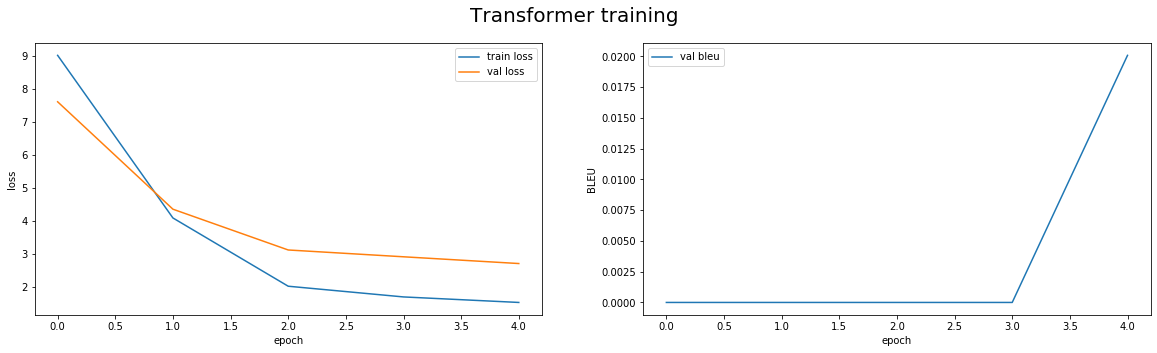

In [49]:
#!g1.1
plot_results(t5_train_loss_list, t5_val_loss_list, t5_val_bleu_list, run_name='Transformer training')

### Итоговое качество модели/примеры переводов

In [50]:
#!g1.1
print(f"Final BLUE score is {t5_val_bleu_list[-1]}.")
print(f"The best BLUE score is {max(t5_val_bleu_list)} on {np.argmax(tran_val_bleu_list) + 1} step.")

Final BLUE score is 0.020077921746769943.
The best BLUE score is 0.020077921746769943 on 5 step.


In [51]:
#!g1.1
print_demo_translations(t5_model, t5_val_dataloader, t5_dm.source_tokenizer)

BLEU score on the following sentences is 0.0.
* Original sentence	| True translation	| Predicted translation
* you know i m not coming back don t you	| ведь знаешь что я больше не вернусь	| знаешь что я не не не не
* i don t live in australia anymore i ve moved to new zeal	| не живу в австралии больше я переехал в новую зеландию	| не не не я а а а а а ав а я я я я я я я
* tom goes to australia three times a year on business	| три раза в год ездит в австралию по делам	| в в в авввстрастра вли
* tom took off his wedding ring and threw it into the pond	| снял обручальное кольцо и бросил его в пруд	| по на на и и в в в в
* it s well known that spiders aren t insects	| известно что пауки не являются насекомыми	| очень что это не
* i thought that tom would apologize but he didn t	| думал том извинится но он не извинился	| думал том не не не он он
* i think it ll be impossible to do that today	| думаю сделать это сегодня будет невозможно	| я это это это сделать
* the children are playing hide

In [52]:
#!g1.1
